# Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

# Dataset

In [2]:
diabetes = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t')

In [3]:
loading = pickle.load(open("datasets/diabetes5000.p", "rb"))

In [4]:
ordering = loading[0] # features numbers in some order
SampleStep = loading[1] # np.array of size 350 with different sample sizes
List_mean = loading[2] # list of log-likelihood means for sample sizes in SampleStep for different number of features (from 1 to 10)
List_var = loading[3] # list of log-likelihood variances for sample sizes in SampleStep for different number of features (from 1 to 10)
X_train = loading[4] # np.array of shape(361, 10) with training data
y_train = loading[5] # np.array of size 361 with training target
X_test = loading[6] # np.array of shape(81, 10) with testing data
y_test = loading[7] # np.array of size 81 with testing target

# Functions

$$ \mathtt{func\_1D\_mean\_approx} = w_0 - w_1^2 \cdot \exp\left( -w_2^2 \cdot m \right) - \dfrac{w_3^2}{m^{3/2}} $$

In [28]:
def func_1D_mean_approx(m, w, features):
    return w[0] -(w[1]**2)*np.exp(-(w[2]**2)*m)-(w[3]**2)/(m**1.5)

$$ \mathtt{func\_1D\_var\_approx} = w_1^2 \cdot \exp\left( - w_2^2 \cdot m \right) + \dfrac{w_3^2}{m^{3/2}} $$

In [29]:
def func_1D_var_approx(m, w, features):
    return (w[1]**2)*np.exp(-(w[2]**2)*m)+(w[3]**2)/(m**1.5)

In [7]:
# SampleStep - np.array with different sample sizes
# List_mean - list of log-likelihood means for sample sizes in SampleStep for different number of features
# SampleStep_approximate - np.array with different sample sizes to approximate
# n - dim of parameters vector w
# M - number of first sample sizes from SampleStep
# verbose - whether or not to use tqdm
# func - function to approximate the mean of log-likelihood
# List_of_w0 - list with initial points for optimizing parameters w
def approxomation_one(SampleStep, List_mean, SampleStep_approximate, n=4, M=None, verbose=False, func=func_1D_mean_approx, List_of_w0=None):

    # list with approximations of log-likelihood means
    List_mean_approximate = []
    
    # initial points for optimizing parameters w
    if List_of_w0 is None:
        List_of_w0 = []
        for i in range(len(List_mean)):
            List_of_w0.append(np.random.normal(size = n))
    
    # zip arrays List_mean and List_of_w0
    List_mean_for = enumerate(zip(List_mean, List_of_w0))
    List_mean_for = tqdm(List_mean_for) if verbose == True else List_mean_for

    # list for estimated parameters w
    List_of_w = []
        
    for i, (mean, w0) in List_mean_for:
        
        if M is not None: # use only first M sample sizes from SampleStep to optimize w
                          # that is we can know less samples than can estimate
            X_train_phi = SampleStep[0:M]
            y_train_phi = mean[0:M]
        else:
            X_train_phi = SampleStep
            y_train_phi = mean
        
        # find parameters w, that minimize MSE between log-likelihood mean and it's approximation
        # start optimizing from w = w0
        minimum = minimize(lambda w: ((func(X_train_phi, w, i+1) - y_train_phi)**2).sum(), w0)

        # append List_mean_approximate with log-likelihood mean approximation
        List_mean_approximate.append(func(SampleStep_approximate, minimum['x'], i+1))

        # append List_of_w with optimal parameters w
        List_of_w.append(minimum['x'])

    return List_mean_approximate, List_of_w

In [9]:
def get_graph(SampleStep, List_mean, SampleStep_approximate, M_SampleStep=[50], n=4, k_for_meaning=100, verbose=False):

    List_of_std_graph = []
    List_of_mean_graph = []
    
    M_SampleStep_for = tqdm(M_SampleStep) if verbose == True else M_SampleStep
    
    for M in M_SampleStep_for:

        Temp_list = []

        for i in range(k_for_meaning):

            List_mean_approximate, List_optimal_w = approxomation_one(SampleStep, List_mean, SampleStep_approximate, n=n, M=M)
            Temp_list.append(List_mean_approximate)
        
        Temp_list = np.array(Temp_list)
        
        List_of_mean_graph.append(np.mean(Temp_list, axis = 0))
        List_of_std_graph.append(np.std(Temp_list, axis = 0))
        
    return List_of_mean_graph, List_of_std_graph

# Some shit

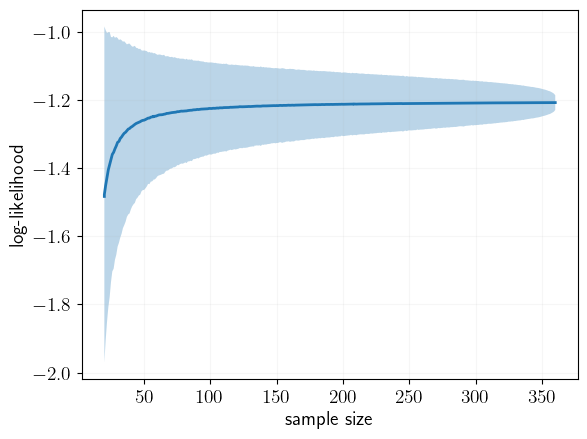

In [47]:
N = 0 # number of features = 1

mean = np.asarray(List_mean[N])
std = np.sqrt(np.asarray(List_var[N]))

plt.plot(SampleStep, mean)
plt.fill_between(SampleStep, mean - std, mean + std, alpha=0.3)

plt.xlabel('sample size')
plt.ylabel('log-likelihood')

plt.show()

In [12]:
l = 26
n = 4
M = 50

In [14]:
M_SampleStep = [50 - l, 100 - l, 150 - l, 200 - l, 250 - l, 300 - l]

SampleStep_approximate = np.linspace(l, 500, 100, dtype=np.int64)

List_of_mean_approximation, List_of_std_approximation = get_graph(SampleStep = SampleStep, 
                                                                  List_mean = List_mean, 
                                                                  SampleStep_approximate = SampleStep_approximate, 
                                                                  M_SampleStep = M_SampleStep, 
                                                                  n = n, 
                                                                  k_for_meaning = 100, 
                                                                  verbose = True)

List_of_std_approximation = np.array(List_of_std_approximation)
List_of_mean_approximation = np.array(List_of_mean_approximation)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [01:18<00:00, 13.13s/it]


In [37]:
SampleStep[:M]

array([20, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int64)

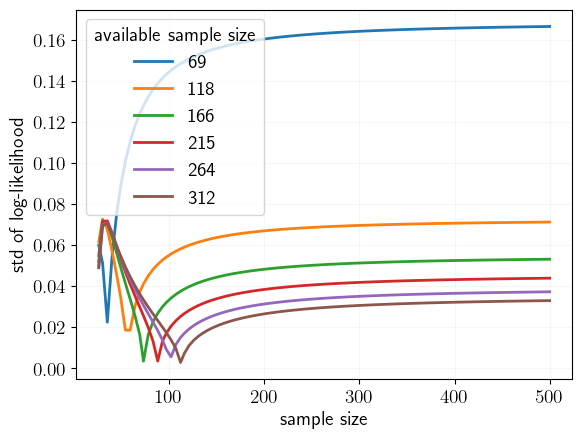

In [46]:
N = 0 # number of features = 1

for i in range(List_of_std_approximation.shape[0]):
    std = np.sqrt(List_of_std_approximation[i, N])
    plt.plot(SampleStep_approximate, std, label = str(SampleStep[M_SampleStep[i]] + l))

plt.legend(title='available sample size')
plt.xlabel('sample size')
plt.ylabel('std of log-likelihood')

plt.show()

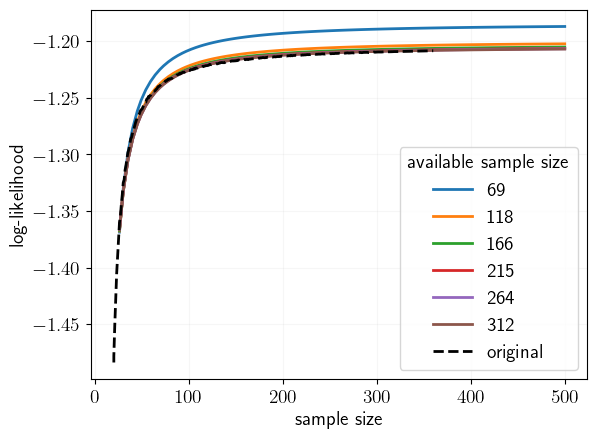

In [56]:
N = 0 # number of features = 1

for i in range(List_of_std_approximation.shape[0]):
    mean = List_of_mean_approximation[i, N]
    plt.plot(SampleStep_approximate, mean, label = str(SampleStep[M_SampleStep[i]] +l))
    
mean = np.asarray(List_mean[N])
std = np.sqrt(np.asarray(List_var[N]))

plt.plot(SampleStep, mean, color='black', linestyle='dashed', label = 'original')

plt.legend(title='available sample size')
plt.xlabel('sample size')
plt.ylabel('log-likelihood')

plt.show()

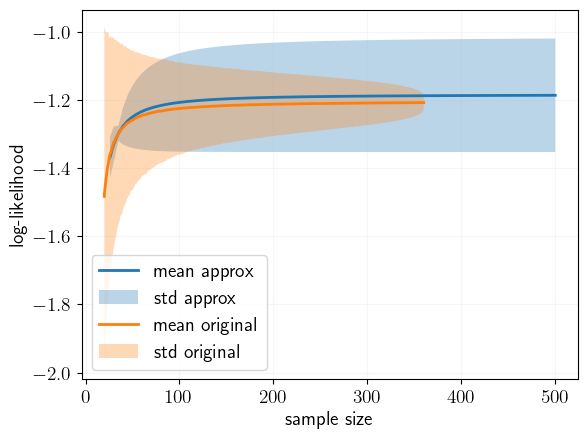

In [67]:
N = 0

List_mean_approximate = List_of_mean_approximation[0]
List_std_approximate = List_of_std_approximation[0]
mean = np.array(List_mean_approximate[N])
std = np.sqrt(np.array(List_std_approximate[N]))

plt.plot(SampleStep_approximate, mean, label='mean approx')
plt.fill_between(SampleStep_approximate, mean - std, mean + std, alpha=0.3, label='std approx')

mean = np.array(List_mean[N])
std = np.sqrt(np.array(List_var[N]))

plt.plot(SampleStep, mean, label='mean original')
plt.fill_between(SampleStep, mean - std, mean + std, alpha=0.3, label='std original')

#plt.plot(50*np.ones(100), np.linspace(-1.3,-1.1, 100), "--", color = 'black')

plt.legend()
plt.xlabel('sample size')
plt.ylabel('log-likelihood')
plt.show()